# 경사 하강법을 이용한 얕은 신경망 학습


In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 하이퍼 파라미터 설정

In [2]:
epochs = 1000

## 네트워크 구조 정의
### 얕은 신경망
#### 입력 계층 : 2, 은닉 계층 : 128 (Sigmoid activation), 출력 계층 : 10 (Softmax activation)

In [3]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(128, input_dim=2, activation='sigmoid')
    self.d2 = tf.keras.layers.Dense(10, activation='softmax')
          
  def call(self, x, training=None, mask=None):
    x = self.d1(x)
    return self.d2(x)

## 학습 루프 정의

In [4]:
@tf.function
def train_step(model, inputs, labels, loss_object, optimizer, train_loss, train_metric):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables) # df(x)/dx
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_metric(labels, predictions)

## 데이터셋 생성, 전처리

In [5]:
np.random.seed(0)

pts = list()
labels = list()
center_pts = np.random.uniform(-8.0, 8.0, (10, 2))
for label, center_pt in enumerate(center_pts):
    for _ in range(100):
        pts.append(center_pt + np.random.randn(*center_pt.shape))
        labels.append(label)

pts = np.stack(pts, axis=0).astype(np.float32)
labels = np.stack(labels, axis=0)

train_ds = tf.data.Dataset.from_tensor_slices((pts, labels)).shuffle(1000).batch(32)

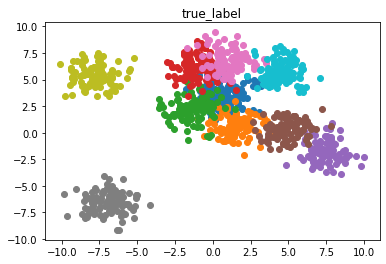

In [17]:
plt.figure()
for idx in range(10):
    mask = labels == idx
    plt.scatter(pts[mask, 0], pts[mask, 1])
plt.title('true_label')
plt.show()

## 모델 생성

In [6]:
model = MyModel()

## 손실 함수 및 최적화 알고리즘 설정
### CrossEntropy, Adam Optimizer

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

## 평가 지표 설정
### Accuracy

In [8]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

## 학습 루프

In [9]:
for epoch in range(epochs):
    for x, label in train_ds:
        train_step(model, x, label, loss_object, optimizer, train_loss, train_accuracy)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100))
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch 1, Loss: 2.2099990844726562, Accuracy: 18.399999618530273
Epoch 2, Loss: 1.8163907527923584, Accuracy: 40.099998474121094
Epoch 3, Loss: 1.5799942016601562, Accuracy: 55.599998474121094
Epoch 4, Loss: 1.4203581809997559, Accuracy: 62.69999694824219
Epoch 5, Loss: 1.2905665636062622, Accuracy: 68.69999694824219
Epoch 6, Loss: 1.1944434642791748, Accuracy: 76.20000457763672
Epoch 7, Loss: 1.1038665771484375, Accuracy: 75.4000015258789
Epoch 8, Loss: 1.0301660299301147, Accuracy: 83.80000305175781
Epoch 9, Loss: 0.9674676656723022, Accuracy: 82.0999984741211
Epoch 10, Loss: 0.9159152507781982, Accuracy: 83.30000305175781
Epoch 11, Loss: 0.857617974281311, Accuracy: 83.80000305175781
Epoch 12, Loss: 0.8182476162910461, Accuracy: 84.69999694824219
Epoch 13, Loss: 0.7784981727600098, Accuracy: 85.0
Epoch 14, Loss: 0.7482726573944092, Accuracy: 83.30000305175781
Epoch 15, Loss: 0.7165828943252563, Accuracy: 86.79999542236328
Epoch 16, Loss: 0.6894015669822693, Accuracy: 86.9000015258789

## 데이터셋 및 학습 파라미터 저장

In [10]:
np.savez_compressed('ch2_dataset.npz', inputs = pts, labels=labels)

In [12]:
W_h, b_h = model.d1.get_weights()
W_o, b_o = model.d2.get_weights()
W_h = np.transpose(W_h)
W_o = np.transpose(W_o)
np.savez_compressed("ch2_parameters.npz",
                    W_h= W_h,
                    W_o = W_o,
                    b_h = b_h,
                    b_o = b_o)